# 🧪 Custom Decision Tree Classification

In this notebook, we implement binary decision tree **from scratch**. We then compare the performance of these implementations with **scikit-learn**'s `DecisionTreeClassifier` model.

### ⚙️ Importing Libraries & Environment Setup

In [1]:
from math import ceil
from typing import Any, Literal

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from numpy.random import Generator as RandomGenerator
from numpy.typing import NDArray
from sklearn.datasets import make_circles
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
    roc_auc_score,
)
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

In [2]:
%matplotlib inline

pd.set_option("display.width", 150)
pd.set_option("display.max_rows", 100)
pd.set_option("display.max_columns", None)

### 🧰 Utility Functions

In [3]:
def evaluate_classification_models(
    predictions: dict[str, NDArray[np.float64]], y: NDArray[np.float64]
) -> pd.DataFrame:
    """Evaluate multiple classification model predictions on the provided dataset.

    Args:
        predictions (dict[str, NDArray[np.float64]]): Dictionary mapping model names
            to predicted target arrays (binary or probabilities) for the dataset.
        y (NDArray[np.float64]): True binary target values of shape (n_samples,).

    Returns:
        pd.DataFrame: DataFrame containing classification metrics — Accuracy, Precision,
            Recall, F1-score, and ROC AUC — for each model. Columns correspond to
            model names, rows correspond to the metric names.
    """
    evaluations = pd.DataFrame(
        columns=predictions.keys(),
        index=["Accuracy", "Precision", "Recall", "F1-score", "ROC AUC"],
    )

    for name, y_pred in predictions.items():
        accuracy = accuracy_score(y, y_pred)
        precision = precision_score(y, y_pred)
        recall = recall_score(y, y_pred)
        f1 = f1_score(y, y_pred)
        roc_auc = roc_auc_score(y, y_pred)

        evaluations.loc[:, name] = [accuracy, precision, recall, f1, roc_auc]

    return evaluations.astype(float)

In [4]:
def plot_confusion_matrices(
    predictions: dict[str, NDArray[np.int64]],
    y_true: NDArray[np.int64],
    n_cols: int = 2,
) -> None:
    """Plot confusion matrices for multiple classification models.

    Each confusion matrix compares the true labels to predictions from one model.
    The plots are arranged in a grid layout for easy comparison.

    Args:
        predictions (dict[str, NDArray[np.int64]]): A dictionary mapping model names to
            their predicted labels (1D array of shape (n_samples,)).
        y_true (NDArray[np.int64]): True class labels (1D array of shape (n_samples,)).
        n_cols (int, optional): Number of columns in the subplot grid layout.
            Default is 2.
    """
    n_models = len(predictions)
    n_cols = min(n_models, n_cols)
    n_rows = ceil(n_models / n_cols)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 5 * n_rows))
    axes = np.array(axes).reshape(-1)

    for ax, (name, y_pred) in zip(axes, predictions.items(), strict=False):
        conf_matrix = confusion_matrix(y_true, y_pred)
        sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False, ax=ax)
        ax.set_xlabel("Predicted Labels")
        ax.set_ylabel("True Labels")
        ax.set_title(name)

    for i in range(n_models, len(axes)):
        fig.delaxes(axes[i])

    plt.tight_layout()
    plt.show()

In [5]:
def plot_decision_tree_boundaries(
    models: dict[str, Any],
    X_train: NDArray[np.float64],
    y_train: NDArray[np.float64],
    n_cols: int = 2,
) -> None:
    """Visualize decision boundaries of trained decision tree models.

    Args:
        models (dict[str, Any]): Dictionary of trained models with `.predict` method.
        X_train (NDArray[np.float64]): Training features of shape (n_samples, 2).
        y_train (NDArray[np.float64]): Training labels of shape (n_samples,).
        n_cols (int): Number of columns in subplot grid.
    """
    x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
    y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300), np.linspace(y_min, y_max, 300))
    grid = np.c_[xx.ravel(), yy.ravel()]

    n_models = len(models)
    n_cols = min(n_models, n_cols)
    n_rows = ceil(n_models / n_cols)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 5 * n_rows))
    axes = np.array(axes).reshape(-1)

    for ax, (name, model) in zip(axes, models.items(), strict=False):
        Z = model.predict(grid).reshape(xx.shape)

        ax.contourf(xx, yy, Z, alpha=0.3, cmap="Set1")
        sns.scatterplot(
            x=X_train[:, 0], y=X_train[:, 1], c=y_train, cmap="Set1", alpha=0.5, ax=ax
        )
        ax.set_xlabel("Feature 1")
        ax.set_ylabel("Feature 2")
        ax.set_title(name)

    for i in range(n_models, len(axes)):
        fig.delaxes(axes[i])

    plt.tight_layout()
    plt.show()

### 📥 Loading the Dataset

In [6]:
# Generate dataset
X, y = make_circles(n_samples=300, noise=0.05, factor=0.5, random_state=0)

In [7]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

### 🧠 Implementing Custom Model Algorithms

In [8]:
class Node:
    """A node in the decision tree.

    Attributes:
        value (int | None): Class label if the node is a leaf, otherwise None.
        feature (int | None): Index of the feature to split on at this node.
        threshold (float | None): Threshold value for the split.
        left (Node | None): Left child node.
        right (Node | None): Right child node.
    """

    def __init__(
        self,
        feature: int | None = None,
        threshold: float | None = None,
        value: int | None = None,
    ) -> None:
        """Initialize a decision tree node.

        Args:
            feature (int | None): Feature index to split on, if applicable.
            threshold (float | None): Threshold value for the split, if applicable.
            value (int | None): Class label for a leaf node.
        """
        self.value = value
        self.feature = feature
        self.threshold = threshold
        self.left: "Node" | None = None
        self.right: "Node" | None = None


class MyDecisionTreeClassifier:
    """A simple binary decision tree classifier.

    This classifier recursively splits the data to minimize the impurity and
    forms a binary tree for classification.

    Attributes:
        max_depth (int): Maximum depth of the tree.
        criterion (Literal["gini", "entropy"]): Impurity criterion to use for splits.
            Defaults to "gini".
        min_samples_split (int): Minimum number of samples required to split an
            internal node.
        min_samples_leaf (int): Minimum number of samples required to be at a leaf node.
        max_features (int | float | Literal["sqrt", "log2"] | None, optional):
            Number or fraction of features to consider when looking for the
            best split. If None, use all features. If 'sqrt', use sqrt(n_features).
            If 'log2', use log2(n_features). If float, selects that fraction of
            total features. If int, selects exactly `max_features` features.
            Defaults to None.
        min_impurity_decrease (float): A node will be split if the impurity
            decrease is at least this value.
        bins (int | None): Optional number of bins to discretize continuous features
            for threshold selection. If None, no binning is applied.
        rng (Generator): NumPy random number generator instance.
        root (Node | None): Root node of the decision tree.
    """

    def __init__(
        self,
        max_depth: int,
        criterion: Literal["gini", "entropy"] = "gini",
        min_samples_split: int = 2,
        min_samples_leaf: int = 1,
        max_features: int | float | Literal["sqrt", "log2"] | None = None,
        min_impurity_decrease: float = 0.0,
        bins: int | None = None,
        random_state: int | None = None,
    ) -> None:
        """Initialize the decision tree classifier.

        Args:
            max_depth (int): Maximum allowed depth of the tree.
            criterion (Literal["gini", "entropy"]): Impurity criterion to use for
                splits. Defaults to "gini".
            min_samples_split (int, optional): Minimum number of samples required to
                split an internal node. Defaults to 2.
            min_samples_leaf (int, optional): Minimum number of samples required to be
                at a leaf node. Defaults to 1.
            max_features (int | float | Literal["sqrt", "log2"] | None, optional):
                Number or fraction of features to consider when looking for the
                best split. If None, use all features. If 'sqrt', use sqrt(n_features).
                If 'log2', use log2(n_features). If float, selects that fraction of
                total features. If int, selects exactly `max_features` features.
                Defaults to None.
            min_impurity_decrease (float, optional): Minimum impurity decrease
                required to make a split. Defaults to 0.0.
            bins (int | None): Optional number of bins to discretize continuous features
                for threshold selection. If None, no binning is applied.
            random_state (int | None, optional): Random seed for reproducibility.
                Defaults to None.
        """
        self.max_depth = max_depth
        self.criterion = criterion
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.max_features = max_features
        self.min_impurity_decrease = min_impurity_decrease
        self.bins = bins

        self.rng: RandomGenerator = np.random.default_rng(random_state)
        self.root: Node | None = None

    def _get_features(self, X: NDArray[np.float64]) -> NDArray[np.int64]:
        """Select a subset of feature indices based on the `max_features` parameter.

        This method determines how many features to consider at each split based on
        the type and value of `max_features`:
            - If int, selects exactly `max_features` features.
            - If float, selects that fraction of total features.
            - If 'sqrt', selects sqrt(n_features).
            - If 'log2', selects log2(n_features).
            - If None: use all features.

        Ensures at least one feature is selected and does not exceed the number
        of available features.

        Args:
            X (NDArray[np.float64]): Input data of shape (n_samples, n_features).

        Returns:
            NDArray[np.int64]: Array of selected feature indices.

        Raises:
            ValueError: If `max_features` is not an int, float, "sqrt", or "log2".
        """
        feature_count = X.shape[1]

        if isinstance(self.max_features, int):
            feature_count = self.max_features
        elif isinstance(self.max_features, float):
            feature_count = int(feature_count * self.max_features)
        elif self.max_features == "sqrt":
            feature_count = int(np.sqrt(feature_count))
        elif self.max_features == "log2":
            feature_count = int(np.log2(feature_count))
        elif self.max_features is not None:
            raise ValueError(f"Unsupported max_features: {self.max_features}")

        feature_count = max(1, min(feature_count, X.shape[1]))
        return self.rng.choice(X.shape[1], feature_count, replace=False)

    def _impurity(self, y: NDArray[np.float64]) -> float:
        """Compute the impurity of a set of class labels using the specified criterion.

        Supports both "gini" and "entropy" as impurity measures.

        Args:
            y (NDArray[np.float64]): Array of class labels.

        Returns:
            float: Computed impurity value.

        Raises:
            ValueError: If an unsupported criterion is specified.
        """
        _, counts = np.unique(y, return_counts=True)
        probabilities = counts / counts.sum()

        if self.criterion == "gini":
            return 1.0 - np.sum(probabilities**2)
        elif self.criterion == "entropy":
            return -np.sum(probabilities * np.log2(probabilities + 1e-10))
        else:
            raise ValueError(f"Unknown criterion: {self.criterion}")

    def _split_dataset(
        self,
        X: NDArray[np.float64],
        y: NDArray[np.float64],
        feature_index: int,
        threshold: float,
    ) -> tuple[
        NDArray[np.float64],
        NDArray[np.float64],
        NDArray[np.float64],
        NDArray[np.float64],
    ]:
        """Split the dataset based on a feature and a threshold.

        Args:
            X (NDArray[np.float64]): Feature matrix.
            y (NDArray[np.float64]): Corresponding labels.
            feature_index (int): Index of the feature to split on.
            threshold (float): Threshold value for the split.

        Returns:
            Tuple of:
                X_left (NDArray[np.float64]): Features where feature <= threshold.
                y_left (NDArray[np.float64]): Labels for X_left.
                X_right (NDArray[np.float64]): Features where feature > threshold.
                y_right (NDArray[np.float64]): Labels for X_right.
        """
        left_mask = X[:, feature_index] <= threshold
        right_mask = X[:, feature_index] > threshold
        return X[left_mask], y[left_mask], X[right_mask], y[right_mask]

    def _get_thresholds_from_bins(
        self, x_column: NDArray[np.float64]
    ) -> NDArray[np.float64]:
        """Compute candidate thresholds.

        If `bins` is None or less than 1, thresholds are computed as midpoints between
        sorted unique values of `x_column`. Otherwise, thresholds are computed
        as midpoints between histogram bin edges based on the specified number of bins.

        Args:
            x_column (NDArray[np.float64]): 1D array of feature values.

        Returns:
            NDArray[np.float64]: Array of unique candidate thresholds.
        """
        if self.bins is None or self.bins < 1:
            x_column_sorted = np.sort(np.unique(x_column))
            thresholds = (x_column_sorted[:-1] + x_column_sorted[1:]) / 2
        else:
            bin_edges = np.histogram_bin_edges(x_column, bins=self.bins)
            thresholds = (bin_edges[:-1] + bin_edges[1:]) / 2

        return thresholds

    def _best_split(
        self, X: NDArray[np.float64], y: NDArray[np.float64]
    ) -> tuple[int, float]:
        """Find the best feature and threshold to split the dataset.

        Args:
            X (NDArray[np.float64]): Feature matrix.
            y (NDArray[np.float64]): Corresponding labels.

        Returns:
            tuple[int, float]: Best feature index and corresponding threshold.
        """
        best_feature: int | None = None
        best_threshold: float | None = None
        best_gain: float = float("-inf")

        current_impurity = self._impurity(y)

        for feature_index in self._get_features(X):
            thresholds = self._get_thresholds_from_bins(X[:, feature_index])
            for threshold in thresholds:
                _, y_left, _, y_right = self._split_dataset(
                    X, y, feature_index, threshold
                )
                if (
                    len(y_left) < self.min_samples_leaf
                    or len(y_right) < self.min_samples_leaf
                ):
                    continue

                left_impurity = self._impurity(y_left)
                right_impurity = self._impurity(y_right)
                weighted_impurity = (
                    len(y_left) * left_impurity + len(y_right) * right_impurity
                ) / len(y)
                impurity_decrease = current_impurity - weighted_impurity
                if (
                    impurity_decrease <= best_gain
                    or impurity_decrease < self.min_impurity_decrease
                ):
                    continue

                best_gain = impurity_decrease
                best_threshold = threshold
                best_feature = feature_index

        return best_feature, best_threshold

    def build(
        self, X: NDArray[np.float64], y: NDArray[np.float64], depth: int = 0
    ) -> Node:
        """Recursively build the decision tree.

        Args:
            X (NDArray[np.float64]): Feature matrix.
            y (NDArray[np.float64]): Labels.
            depth (int, optional): Current depth of the tree. Defaults to 0.

        Returns:
            Node: Root node of the constructed subtree.
        """
        if (
            len(np.unique(y)) == 1
            or len(y) < self.min_samples_split
            or depth == self.max_depth
        ):
            leaf_value = np.bincount(y).argmax()
            return Node(value=leaf_value)

        feature, threshold = self._best_split(X, y)
        if feature is None:
            leaf_value = np.bincount(y).argmax()
            return Node(value=leaf_value)

        X_left, y_left, X_right, y_right = self._split_dataset(X, y, feature, threshold)

        node = Node(feature=feature, threshold=threshold)
        node.left = self.build(X_left, y_left, depth + 1)
        node.right = self.build(X_right, y_right, depth + 1)

        return node

    def fit(self, X: NDArray[np.float64], y: NDArray[np.float64]) -> None:
        """Train the decision tree on the provided dataset.

        Args:
            X (NDArray[np.float64]): Feature matrix of shape (n_samples, n_features).
            y (NDArray[np.float64]): Labels of shape (n_samples,).
        """
        self.root = self.build(X, y)

    def _predict_one(self, x: NDArray[np.float64], node: Node | None = None) -> int:
        """Predict the label for a single data point.

        Args:
            x (NDArray[np.float64]): Input feature vector.
            node (Node | None, optional): Current node in the tree. Defaults to root.

        Returns:
            int: Predicted class label.
        """
        if node is None:
            node = self.root

        if node.value is not None:
            return node.value

        if x[node.feature] <= node.threshold:
            return self._predict_one(x, node.left)
        return self._predict_one(x, node.right)

    def predict(self, X: NDArray[np.float64]) -> NDArray[np.float64]:
        """Predict the labels for a batch of input samples.

        Args:
            X (NDArray[np.float64]): Feature matrix of shape (n_samples, n_features).

        Returns:
            NDArray[np.float64]: Predicted labels for each sample.
        """
        return np.array([self._predict_one(x) for x in X])

### 🏋️‍♂️ Model Training

In [9]:
# Scikit-learn decision tree classifier model
sklearn_model = DecisionTreeClassifier(max_depth=4, random_state=42)
sklearn_model.fit(X_train, y_train)

# My decision tree classifier model
my_model = MyDecisionTreeClassifier(max_depth=4, random_state=42)
my_model.fit(X_train, y_train)

### 📊 Comparing Algorithm Versions

In [10]:
predictions = {
    "scikit-learn": sklearn_model.predict(X_test),
    "my": my_model.predict(X_test),
}

models = {
    "scikit-learn": sklearn_model,
    "my": my_model,
}

In [11]:
evaluate_classification_models(predictions, y_test)

,scikit-learn,my
Accuracy,1.0,1.0
Precision,1.0,1.0
Recall,1.0,1.0
F1-score,1.0,1.0
ROC AUC,1.0,1.0


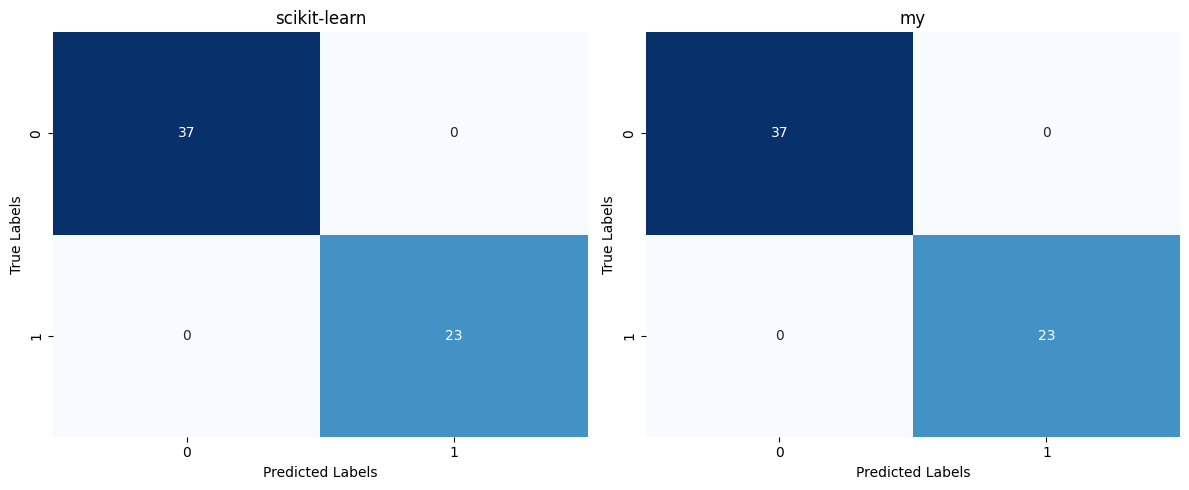

In [12]:
plot_confusion_matrices(predictions, y_test)

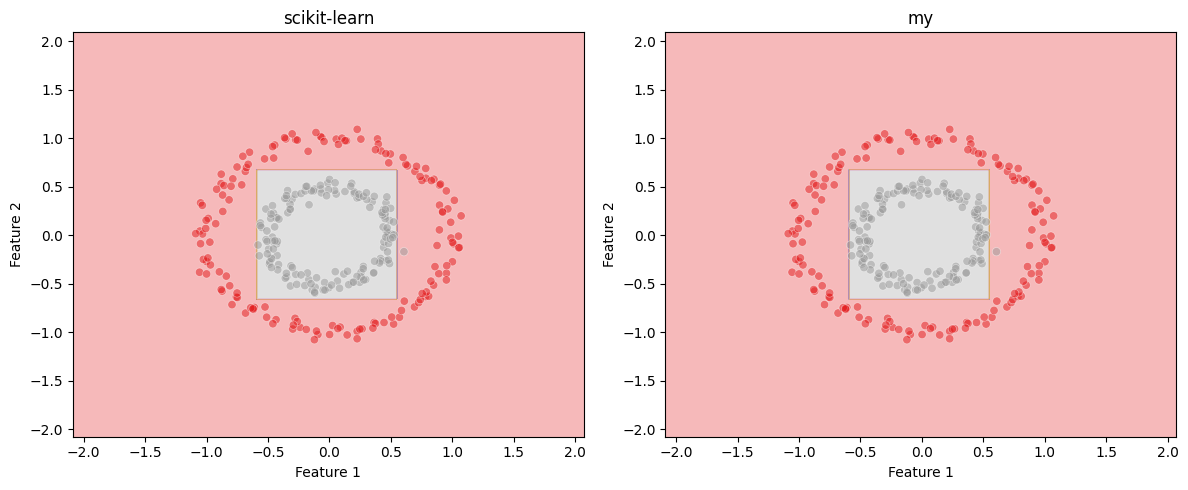

In [13]:
plot_decision_tree_boundaries(models, X, y)